In [25]:
import pandas as pd
import numpy as np
import os
import sys
import joblib
import shap
import torch
import pickle
import matplotlib.pyplot as plt
from models.mlp import MLP
from models.tab_transformer import TabTransformer

# print the JS visualization code to the notebook
shap.initjs()

In [26]:
# System settings
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load test data
test_data = pd.read_csv('./data/3_test_processed.csv')
X = test_data.drop(columns=['credit_score'], axis=1)
y = test_data['credit_score']

# Save SHAP values
shap_path = './shap/'
# Load model - Logistic Regression, XGBoost, MLP, TabTransformer
model_path = './models/'
# Logistic Regression and XGBoost have joblib files
logistic_regression_model = joblib.load(os.path.join(model_path, 'logistic_regression.joblib'))
xgboost_model = joblib.load(os.path.join(model_path, 'xgboost.joblib'))
# MLP and TabTransformer have pth files
mlp_best_model_state = torch.load(os.path.join(model_path, 'mlp_best_state.pth'))
mlp_best_model = MLP(input_dim=X.shape[1], num_classes=3).to(device)
mlp_best_model.load_state_dict(mlp_best_model_state)
tab_transformer_best_model_state = torch.load(os.path.join(model_path, 'tab_transformer_best_state.pth'))
tab_transformer_best_model = TabTransformer(input_dim=X.shape[1], num_classes=3).to(device)
tab_transformer_best_model.load_state_dict(tab_transformer_best_model_state)

<All keys matched successfully>

In [27]:
save = True
os.makedirs(shap_path, exist_ok=True)

if save:
    # SHAP Explain - Logistic Regression
    logistic_regression_explainer = shap.Explainer(logistic_regression_model, X)
    logistic_regression_shap_values = logistic_regression_explainer(X)

    # Logistic Regression
    with open(os.path.join(shap_path, 'logistic_regression_shap.pkl'), 'wb') as f:
        pickle.dump(logistic_regression_shap_values, f)

    # SHAP Explain - XGBoost
    xgboost_explainer = shap.TreeExplainer(xgboost_model, X)
    xgboost_shap_values = xgboost_explainer(X)

    # XGBoost
    with open(os.path.join(shap_path, 'xgboost_shap.pkl'), 'wb') as f:
        pickle.dump(xgboost_shap_values, f)

    # SHAP Explain - MLP
    mlp_best_model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
    background = X_tensor[:100]
    mlp_explainer = shap.DeepExplainer(mlp_best_model, background)
    mlp_shap_values = mlp_explainer.shap_values(X_tensor)

    # MLP
    with open(os.path.join(shap_path, 'mlp_shap.pkl'), 'wb') as f:
        pickle.dump(mlp_shap_values, f)

    # SHAP Explain - TabTransformer
    tab_transformer_best_model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
    background = X_tensor[:100]
    tab_transformer_explainer = shap.DeepExplainer(tab_transformer_best_model, background)
    tab_transformer_shap_values = tab_transformer_explainer.shap_values(
        X_tensor, check_additivity=False
    )

    # TabTransformer
    with open(os.path.join(shap_path, 'tab_transformer_shap.pkl'), 'wb') as f:
        pickle.dump(tab_transformer_shap_values, f)
else:
    # Load SHAP values
    with open(os.path.join(shap_path, 'logistic_regression_shap.pkl'), 'rb') as f:
        logistic_regression_shap_values = pickle.load(f)

    with open(os.path.join(shap_path, 'xgboost_shap.pkl'), 'rb') as f:
        xgboost_shap_values = pickle.load(f)

    # Load SHAP values
    with open(os.path.join(shap_path, 'mlp_shap.pkl'), 'rb') as f:
        mlp_shap_values = pickle.load(f)
    
    with open(os.path.join(shap_path, 'tab_transformer_shap.pkl'), 'rb') as f:
        tab_transformer_shap_values = pickle.load(f)

100%|===================| 53188/53325 [05:49<00:00]        /cs/student/projects1/dsml/2024/zecaox01/miniconda3/envs/finance/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f"unrecognized nn.Module: {module_type}")


In [38]:
def is_multiclass_shap_values(shap_values):
    if isinstance(shap_values, list):
        return True
    elif hasattr(shap_values, "values"):
        vals = shap_values.values
        return isinstance(vals, np.ndarray) and vals.ndim == 3
    elif hasattr(shap_values, "__len__") and len(shap_values) > 0 and isinstance(shap_values[0], np.ndarray):
        return True
    return False

def global_shap_plot(shap_values, X, model_name, class_idx=2, seed=42):
    """
    Save summary dot plot and bar plot with support for SHAP Explanation and list-style shap_values
    """
    import shap
    rng = np.random.default_rng(seed)
    
    is_multiclass = is_multiclass_shap_values(shap_values)
    print(f"[INFO] SHAP values for '{model_name}' is_multiclass = {is_multiclass}")

    if is_multiclass:
        shap.summary_plot(shap_values[:, :, class_idx], X, show=False, plot_type="dot", rng=rng)
        plt.savefig(os.path.join(shap_path, f"{model_name}_summary_dot_class{class_idx}.png"), bbox_inches='tight')
        plt.clf()

        # bar plot (aggregated)
        shap.summary_plot(shap_values, X, show=False, plot_type="bar", rng=rng)
        plt.savefig(os.path.join(shap_path, f"{model_name}_summary_bar_allclasses.png"), bbox_inches='tight')
        plt.clf()
    else:
        shap.summary_plot(shap_values, X, show=False, plot_type="dot", rng=rng)
        plt.savefig(os.path.join(shap_path, f"{model_name}_summary_dot.png"), bbox_inches='tight')
        plt.clf()

        shap.summary_plot(shap_values, X, show=False, plot_type="bar", rng=rng)
        plt.savefig(os.path.join(shap_path, f"{model_name}_summary_bar.png"), bbox_inches='tight')
        plt.clf()


global_shap_plot(logistic_regression_shap_values, X, "logistic_regression", class_idx=2)
global_shap_plot(xgboost_shap_values, X, "xgboost")
global_shap_plot(mlp_shap_values, X, "mlp")
global_shap_plot(tab_transformer_shap_values, X, "tab_transformer")

[INFO] SHAP values for 'logistic_regression' is_multiclass = True
[INFO] SHAP values for 'xgboost' is_multiclass = True
[INFO] SHAP values for 'mlp' is_multiclass = True
[INFO] SHAP values for 'tab_transformer' is_multiclass = True


<Figure size 800x950 with 0 Axes>


处理模型: logistic_regression


/tmp/ipykernel_812516/2590697186.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


[✓] 已保存摘要图 PNG: ./shap/logistic_regression_summary_class2.png


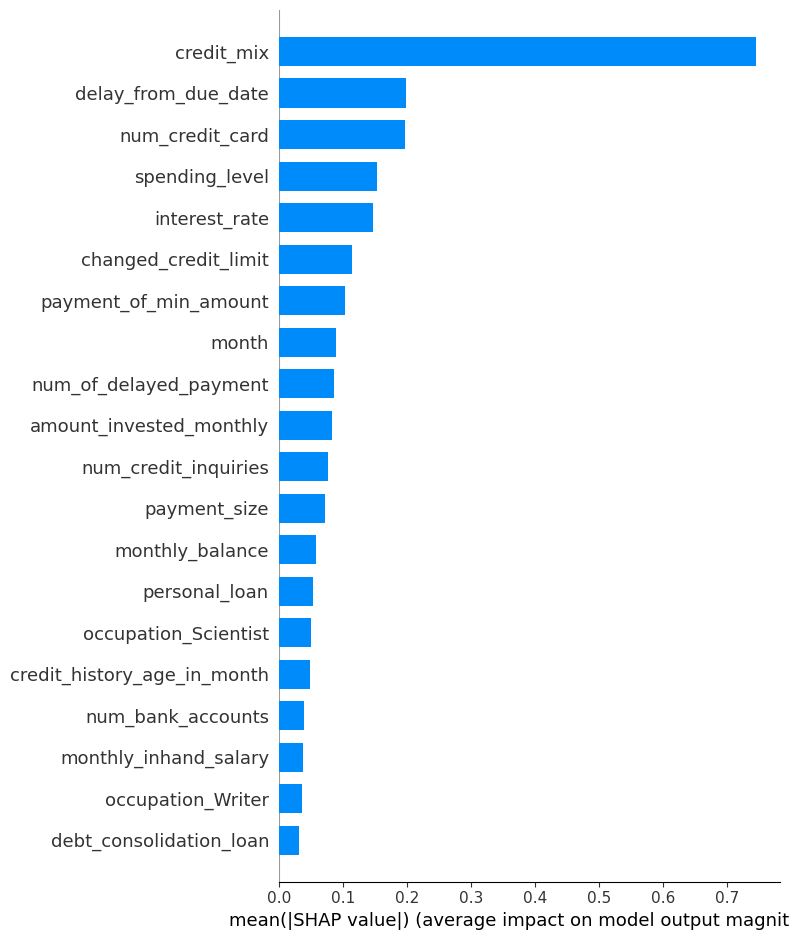

[✓] 已保存条形图 PNG: ./shap/logistic_regression_barplot_sample0_class2.png


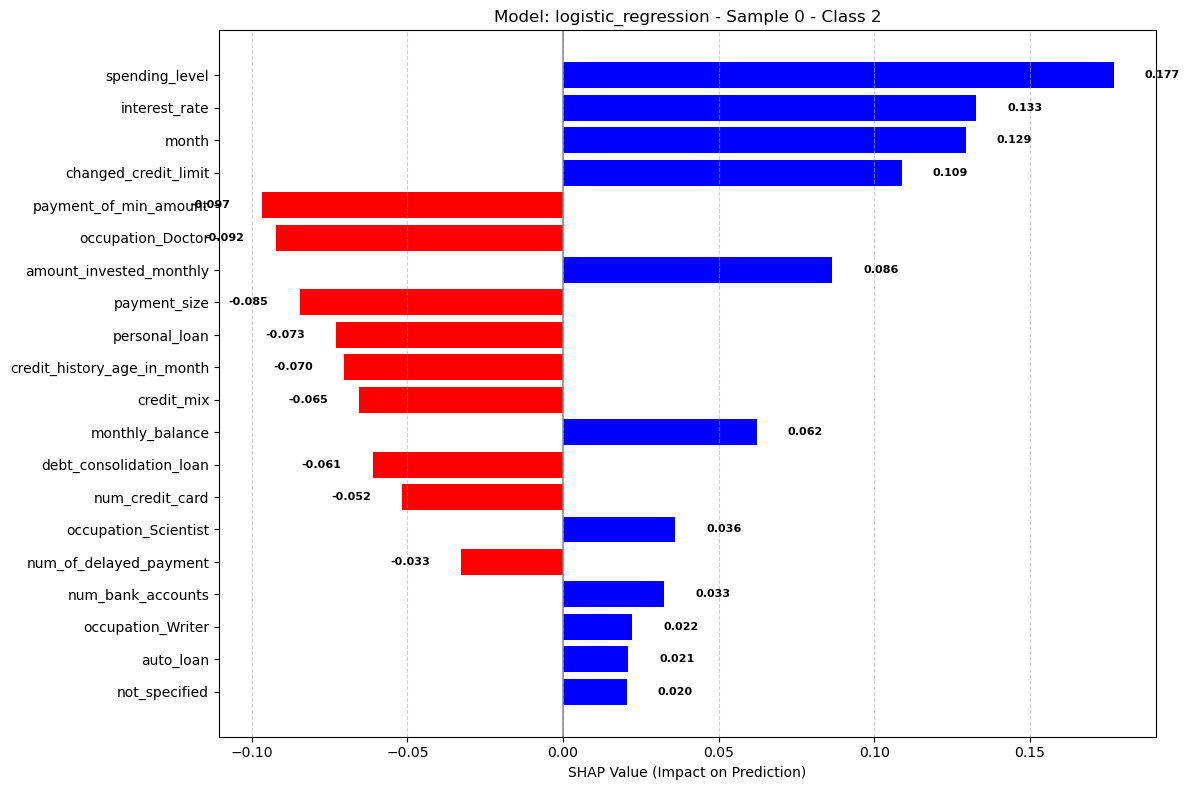


处理模型: xgboost


/tmp/ipykernel_812516/2590697186.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


[✓] 已保存摘要图 PNG: ./shap/xgboost_summary_class2.png


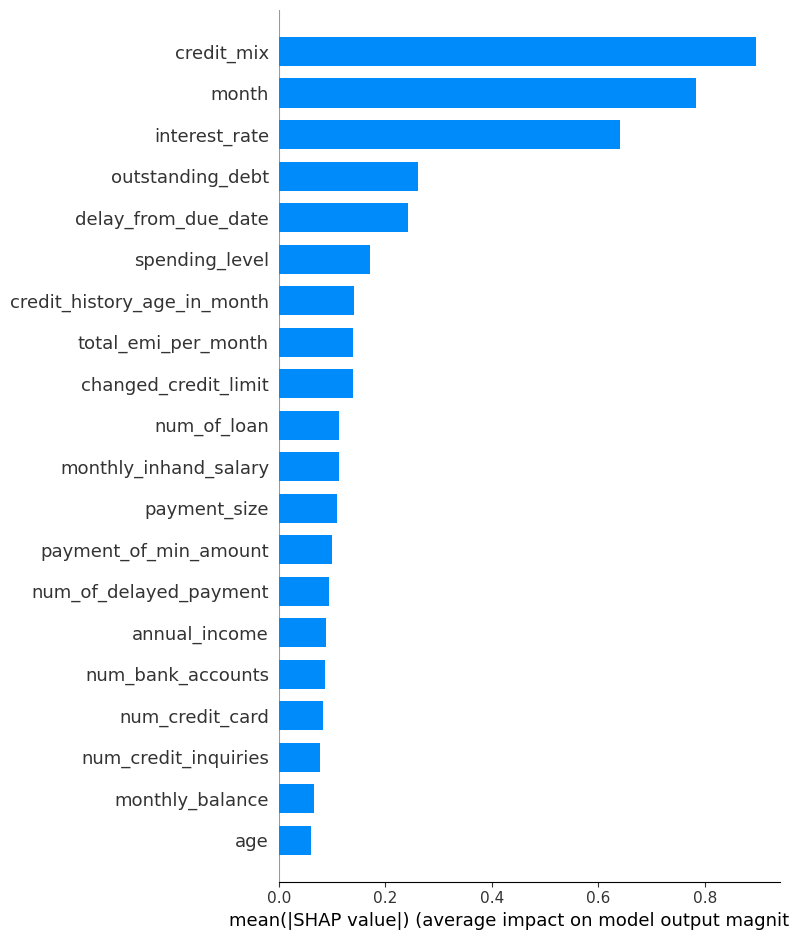

[✓] 已保存条形图 PNG: ./shap/xgboost_barplot_sample0_class2.png


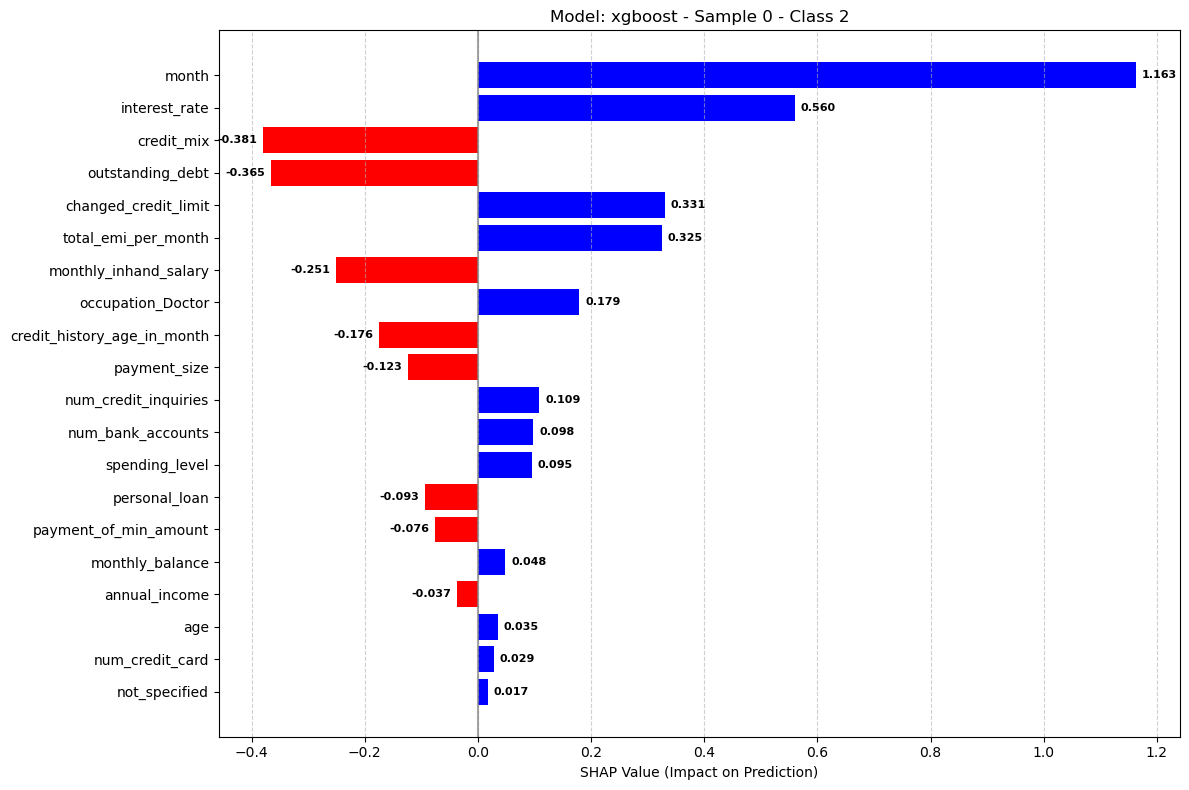


处理模型: mlp


/tmp/ipykernel_812516/2590697186.py:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals_to_plot, X, plot_type="bar", show=False, max_display=20)


[✓] 已保存摘要图 PNG: ./shap/mlp_summary_class2.png


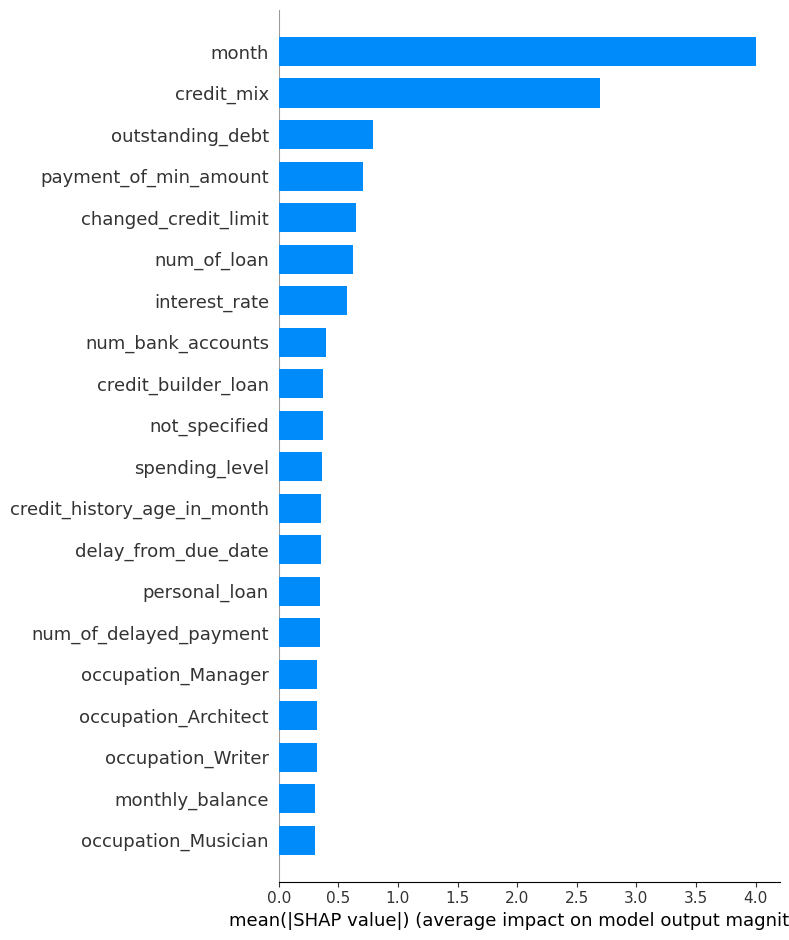

[✓] 已保存条形图 PNG: ./shap/mlp_barplot_sample0_class2.png


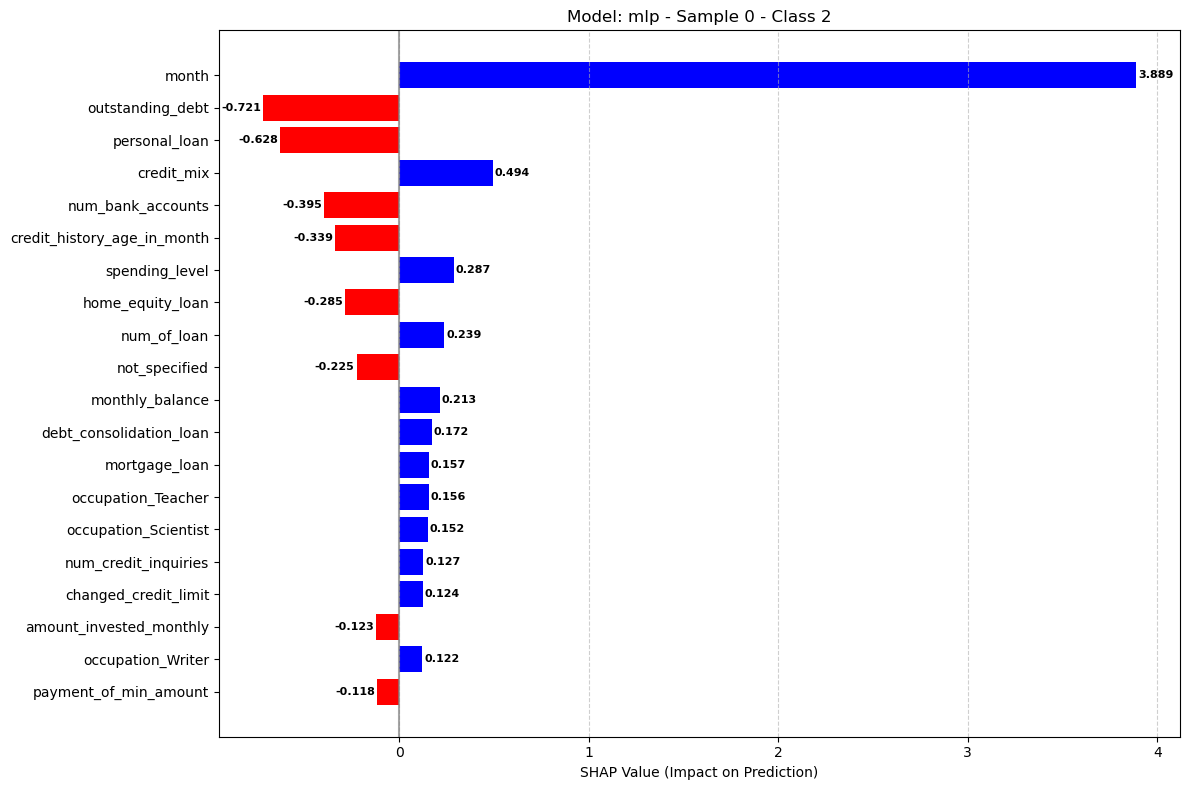


处理模型: tab_transformer


/tmp/ipykernel_812516/2590697186.py:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals_to_plot, X, plot_type="bar", show=False, max_display=20)


[✓] 已保存摘要图 PNG: ./shap/tab_transformer_summary_class2.png


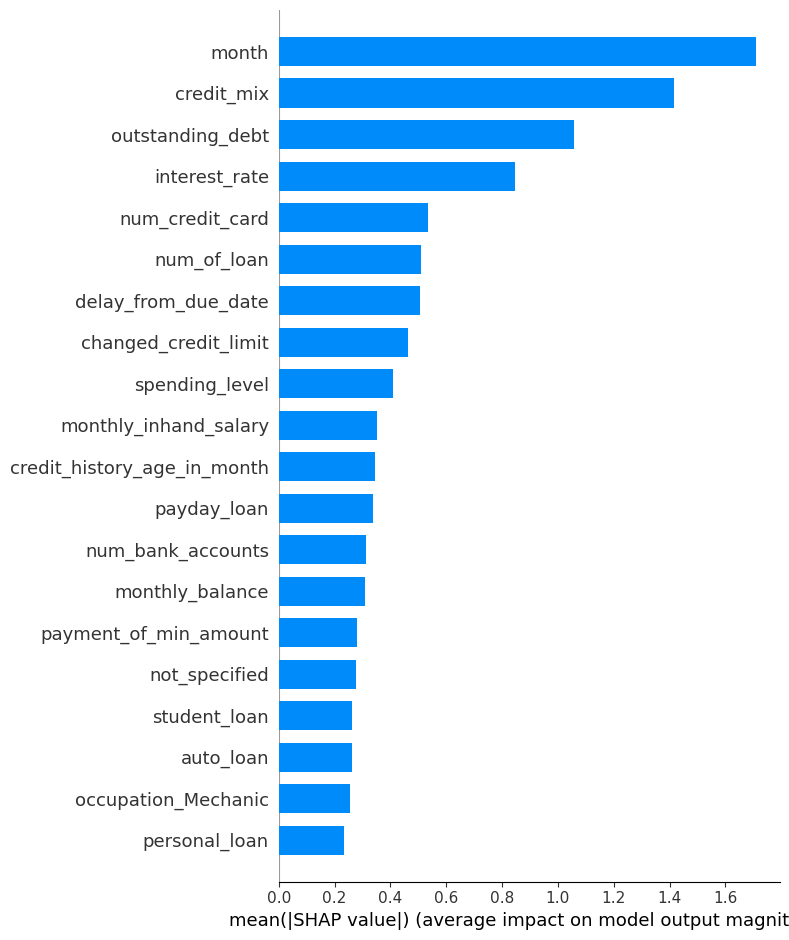

[✓] 已保存条形图 PNG: ./shap/tab_transformer_barplot_sample0_class2.png


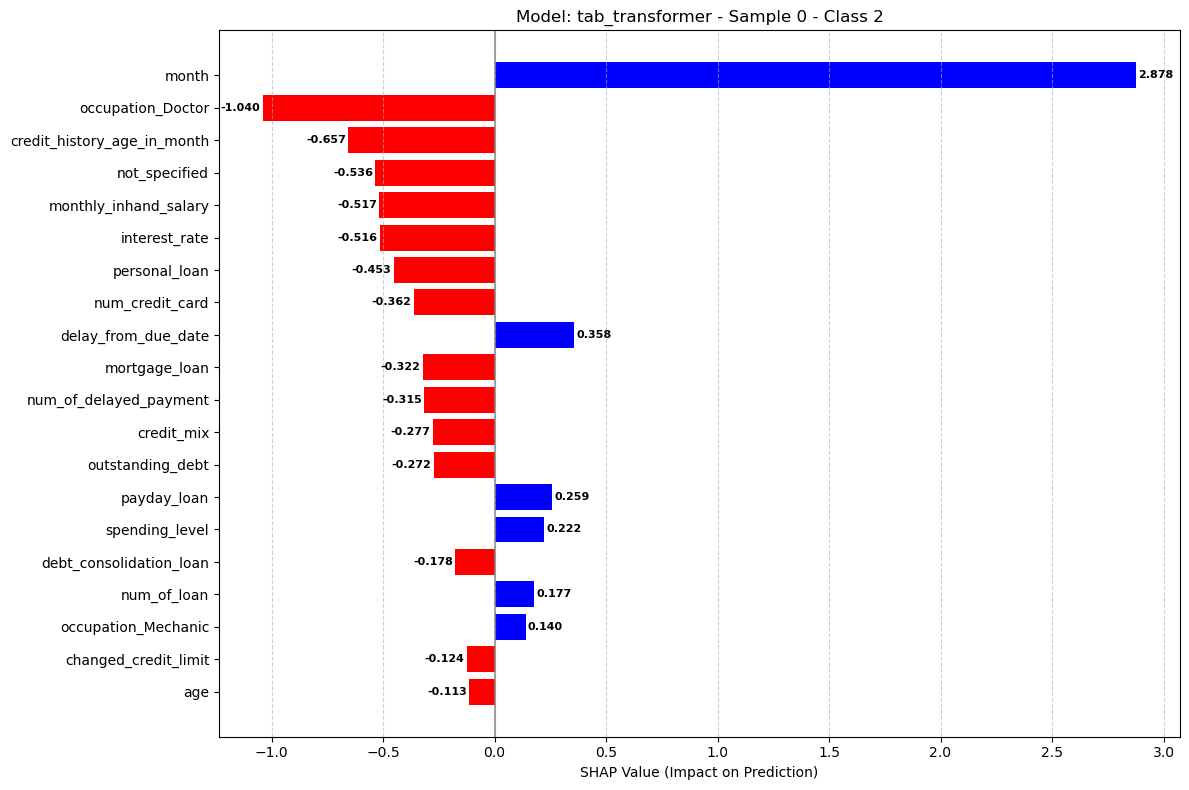

In [47]:
def save_shap_plot_as_png(explainer, shap_values, X, sample_index, model_name, class_idx=2, 
                           shap_path='./shap_plots', display_in_notebook=True):
    """
    创建SHAP可视化并保存为PNG格式 - 专门处理多类别问题
    """
    import shap
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    
    os.makedirs(shap_path, exist_ok=True)
    
    # 获取样本数据和特征名称
    feature_row = X.iloc[sample_index]
    feature_names = X.columns.tolist()
    
    try:
        # ===== 方法1: 对所有样本的特征重要性摘要图 =====
        plt.figure(figsize=(12, 8))
        
        # 处理多类别Explanation对象
        if isinstance(shap_values, shap.Explanation):
            # 从多类别Explanation中提取特定类别
            if len(shap_values.shape) == 3:  # (样本数, 特征数, 类别数)
                # 选择特定类别的所有样本数据
                class_shap_values = shap_values[:, :, class_idx]
                
                # 使用bar plot而不是beeswarm plot
                shap.summary_plot(
                    class_shap_values, 
                    X,
                    plot_type="bar",  # 使用条形图而不是蜂群图
                    show=False,
                    max_display=20
                )
            else:
                # 单类别情况
                shap.summary_plot(shap_values, X, plot_type="bar", show=False, max_display=20)
        else:
            # 处理其他类型的SHAP值
            if isinstance(shap_values, list):
                vals_to_plot = shap_values[class_idx]
            elif isinstance(shap_values, np.ndarray):
                if len(shap_values.shape) > 2:  # 多类别
                    vals_to_plot = shap_values[:, :, class_idx]
                else:
                    vals_to_plot = shap_values
                
            shap.summary_plot(vals_to_plot, X, plot_type="bar", show=False, max_display=20)
        
        plt.tight_layout()
        
        # 保存PNG
        summary_path = os.path.join(shap_path, f"{model_name}_summary_class{class_idx}.png")
        plt.savefig(summary_path, bbox_inches='tight', dpi=300)
        print(f"[✓] 已保存摘要图 PNG: {summary_path}")
        
        if display_in_notebook:
            plt.show()
        else:
            plt.close()
            
        # ===== 方法2: 单个样本的条形图 =====
        plt.figure(figsize=(12, 8))
        
        # 提取单个样本的SHAP值
        try:
            if isinstance(shap_values, shap.Explanation):
                # 从多类别Explanation提取单个样本和特定类别
                if len(shap_values.shape) == 3:  # (样本, 特征, 类别)
                    sample_values = shap_values[sample_index, :, class_idx].values
                else:
                    sample_values = shap_values[sample_index].values
            elif isinstance(shap_values, list):
                sample_values = shap_values[class_idx][sample_index]
            elif isinstance(shap_values, np.ndarray):
                if shap_values.ndim > 2:  # 多类别 [样本, 特征, 类别]
                    sample_values = shap_values[sample_index, :, class_idx]
                elif shap_values.ndim == 2:  # [样本, 特征]
                    sample_values = shap_values[sample_index]
                else:
                    sample_values = shap_values
                    
            # 排序并绘制顶部特征
            indices = np.argsort(np.abs(sample_values))
            n_features = min(20, len(sample_values))
            indices = indices[-n_features:]
            
            feature_labels = [feature_names[i] for i in indices]
            values = [sample_values[i] for i in indices]
            
            # 绘制条形图
            bars = plt.barh(range(len(feature_labels)), values, color=['red' if x < 0 else 'blue' for x in values])
            plt.yticks(range(len(feature_labels)), feature_labels)
            plt.xlabel('SHAP Value (Impact on Prediction)')
            plt.title(f'Model: {model_name} - Sample {sample_index} - Class {class_idx}')
            plt.grid(axis='x', linestyle='--', alpha=0.6)
            plt.axvline(x=0, color='grey', linestyle='-', alpha=0.7)
            
            # 添加值标签
            for i, bar in enumerate(bars):
                width = bar.get_width()
                label_x_pos = width + 0.01 if width >= 0 else width - 0.01
                alignment = 'left' if width >= 0 else 'right'
                plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                        f'{width:.3f}', va='center', ha=alignment,
                        color='black', fontweight='bold', fontsize=8)
            
            plt.tight_layout()
            
            # 保存PNG
            bar_path = os.path.join(shap_path, f"{model_name}_barplot_sample{sample_index}_class{class_idx}.png")
            plt.savefig(bar_path, bbox_inches='tight', dpi=300)
            print(f"[✓] 已保存条形图 PNG: {bar_path}")
            
            if display_in_notebook:
                plt.show()
            else:
                plt.close()
        except Exception as e2:
            print(f"生成样本条形图失败: {str(e2)}")
            
        return True
        
    except Exception as e:
        print(f"可视化失败: {str(e)}")
        
        # 打印调试信息
        print("\n调试信息:")
        print(f"- explainer.expected_value 类型: {type(explainer.expected_value)}")
        print(f"- shap_values 类型: {type(shap_values)}")
        
        if isinstance(shap_values, shap.Explanation):
            print(f"- shap_values 形状: {shap_values.shape}")
            
            # 尝试直接使用matplotlib创建简单的条形图
            try:
                print("尝试使用备选方法创建图表...")
                plt.figure(figsize=(12, 8))
                
                # 提取单个样本和类别
                if len(shap_values.shape) == 3:
                    sample_data = shap_values[sample_index, :, class_idx].values
                else:
                    sample_data = shap_values[sample_index].values
                
                # 按绝对值排序
                sorted_idx = np.argsort(np.abs(sample_data))[-20:]
                plt.barh(range(len(sorted_idx)), [sample_data[i] for i in sorted_idx],
                        color=['red' if x < 0 else 'green' for x in [sample_data[i] for i in sorted_idx]])
                plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
                plt.title(f"{model_name} - 样本 {sample_index} - 类别 {class_idx} (备选图)")
                plt.tight_layout()
                
                # 保存PNG
                alt_path = os.path.join(shap_path, f"{model_name}_alternative_sample{sample_index}_class{class_idx}.png")
                plt.savefig(alt_path, bbox_inches='tight', dpi=300)
                print(f"[✓] 已保存备选图 PNG: {alt_path}")
                
                if display_in_notebook:
                    plt.show()
                else:
                    plt.close()
                
            except Exception as alt_e:
                print(f"备选方法也失败: {str(alt_e)}")
        
        return False
    
# print the JS visualization code to the notebook
shap.initjs()

# 确保SHAP初始化
shap.initjs()

# 为所有模型生成可视化
models_data = [
    ("logistic_regression", logistic_regression_explainer, logistic_regression_shap_values),
    ("xgboost", xgboost_explainer, xgboost_shap_values),
    ("mlp", mlp_explainer, mlp_shap_values),
    ("tab_transformer", tab_transformer_explainer, tab_transformer_shap_values)
]

for model_name, explainer, shap_values in models_data:
    print(f"\n处理模型: {model_name}")
    save_shap_plot_as_png(
        explainer, shap_values, X, sample_index=0,
        model_name=model_name, class_idx=2, shap_path=shap_path
    )